## 1. 定义算法

### 1.1. 定义模型

注意DDGP中critic网络的输入是state加上action。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim = 256, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
        
class Critic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim=256, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### 1.2 定义经验回放

In [2]:
from collections import deque
import random
class ReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        '''_summary_
        Args:
            trainsitions (tuple): _description_
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        if sequential: # sequential sampling
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else:
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        self.buffer.clear()
    def __len__(self):
        return len(self.buffer)

In [3]:
import torch.optim as optim
import numpy as np
class DDPG:
    def __init__(self, models,memories,cfg):
        self.device = torch.device(cfg['device'])
        self.critic = models['critic'].to(self.device)
        self.target_critic = models['critic'].to(self.device)
        self.actor = models['actor'].to(self.device)
        self.target_actor = models['actor'].to(self.device)
        
        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),  lr=cfg['critic_lr'])
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg['actor_lr'])
        self.memory = memories['memory']
        self.batch_size = cfg['batch_size']
        self.gamma = cfg['gamma']
        self.tau = cfg['tau']  # 软更新参数
    def sample_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.detach().cpu().numpy()[0, 0]
    @torch.no_grad()
    def predict_action(self, state):
        ''' 用于预测，不需要计算梯度
        '''
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.cpu().numpy()[0, 0]
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中中随机采样一个批量的transition
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        # 注意看伪代码，这里的actor损失就是对应策略即actor输出的action下对应critic值的负均值
        actor_loss = self.critic(state, self.actor(state))
        actor_loss = - actor_loss.mean()

        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())
        # 这里的expected_value就是伪代码中间的y_i  
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)

        actual_value = self.critic(state, action)
        critic_loss = nn.MSELoss()(actual_value, expected_value.detach())
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        # 各自目标网络的参数软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.tau) +
                param.data * self.tau
            )

## 2. 定义训练

注意测试函数中不需要动作噪声

In [4]:
class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.n_actions   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.n_actions) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

def train(cfg, env, agent):
    print("开始训练！")
    ou_noise = OUNoise(env.action_space)  # 动作噪声
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg['train_eps']):
        state = env.reset()
        ou_noise.reset()
        ep_reward = 0
        for i_step in range(cfg['max_steps']):
            action = agent.sample_action(state)
            action = ou_noise.get_action(action, i_step+1) 
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push((state, action, reward, next_state, done))
            agent.update()
            state = next_state
            if done:
                break
        if (i_ep+1)%10 == 0:
            print(f"回合：{i_ep+1}/{cfg['train_eps']}，奖励：{ep_reward:.2f}")
        rewards.append(ep_reward)
    print("完成训练！")
    return {'rewards':rewards}
def test(cfg, env, agent):
    print("开始测试！")
    rewards = [] # 记录所有回合的奖励
    for i_ep in range(cfg['test_eps']):
        state = env.reset() 
        ep_reward = 0
        for i_step in range(cfg['max_steps']):
            action = agent.predict_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg['test_eps']}，奖励：{ep_reward:.2f}")
    print("完成测试！")
    return {'rewards':rewards}

## 3. 定义环境

In [ ]:
import gym
import os
import torch
import numpy as np
import random
class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action
def all_seed(env,seed = 1):
    ''' 万能的seed函数
    '''
    env.seed(seed) # env config
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # config for CPU
    torch.cuda.manual_seed(seed) # config for GPU
    os.environ['PYTHONHASHSEED'] = str(seed) # config for python scripts
    # config for cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = NormalizedActions(gym.make(cfg['env_name'])) # 装饰action噪声
    if cfg['seed'] !=0:
        all_seed(env,seed=cfg['seed'])
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    cfg.update({"n_states":n_states,"n_actions":n_actions}) # 更新n_states和n_actions到cfg参数中
    models = {"actor":Actor(n_states,n_actions,hidden_dim=cfg['actor_hidden_dim']),"critic":Critic(n_states,n_actions,hidden_dim=cfg['critic_hidden_dim'])}
    memories = {"memory":ReplayBuffer(cfg['memory_capacity'])}
    agent = DDPG(models,memories,cfg)
    return env,agent

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 4. 设置参数

In [6]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
def get_args():
    """ 超参数
    """
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DDPG',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='Pendulum-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=500,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--max_steps',default=100000,type=int,help="steps per episode, much larger value can simulate infinite steps")
    parser.add_argument('--gamma',default=0.99,type=float,help="discounted factor")
    parser.add_argument('--critic_lr',default=1e-3,type=float,help="learning rate of critic")
    parser.add_argument('--actor_lr',default=1e-4,type=float,help="learning rate of actor")
    parser.add_argument('--memory_capacity',default=8000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=128,type=int)
    parser.add_argument('--target_update',default=2,type=int)
    parser.add_argument('--tau',default=1e-2,type=float)
    parser.add_argument('--critic_hidden_dim',default=256,type=int)
    parser.add_argument('--actor_hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda")  
    parser.add_argument('--seed',default=1,type=int,help="random seed")
    args = parser.parse_args([])    
    args = {**vars(args)} # 将args转换为字典  
    # 打印参数
    print("训练参数如下：")
    print(''.join(['=']*80))
    tplt = "{:^20}\t{:^20}\t{:^20}"
    print(tplt.format("参数名","参数值","参数类型"))
    for k,v in args.items():
        print(tplt.format(k,v,str(type(v))))   
    print(''.join(['=']*80))                  
    return args
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth

    Args:
        data (List):输入数据
        weight (Float): 平滑权重，处于0-1之间，数值越高说明越平滑，一般取0.9

    Returns:
        smoothed (List): 平滑后的数据
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg,path=None,tag='train'):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg['device']} of {cfg['algo_name']} for {cfg['env_name']}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


## 5. 我准备好了！

训练参数如下：
        参数名         	        参数值         	        参数类型        
     algo_name      	        DDPG        	   <class 'str'>    
      env_name      	    Pendulum-v1     	   <class 'str'>    
     train_eps      	        500         	   <class 'int'>    
      test_eps      	         20         	   <class 'int'>    
     max_steps      	       100000       	   <class 'int'>    
       gamma        	        0.99        	  <class 'float'>   
     critic_lr      	       0.001        	  <class 'float'>   
      actor_lr      	       0.0001       	  <class 'float'>   
  memory_capacity   	        8000        	   <class 'int'>    
     batch_size     	        128         	   <class 'int'>    
   target_update    	         2          	   <class 'int'>    
        tau         	        0.01        	  <class 'float'>   
 critic_hidden_dim  	        256         	   <class 'int'>    
  actor_hidden_dim  	        256         	   <class 'int'>    
       device       	        cpu         	   <c

/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/opt/anaconda3/lib/python3.12/site-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for remova

开始训练！


/opt/anaconda3/lib/python3.12/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


回合：10/500，奖励：-1179.10
回合：20/500，奖励：-742.92
回合：30/500，奖励：-890.21
回合：40/500，奖励：-116.73
回合：50/500，奖励：-1204.42
回合：60/500，奖励：-512.53
回合：70/500，奖励：-497.41
回合：80/500，奖励：-372.42
回合：90/500，奖励：-1388.48
回合：100/500，奖励：-469.35
回合：110/500，奖励：-362.15
回合：120/500，奖励：-764.88
回合：130/500，奖励：-717.21
回合：140/500，奖励：-480.64
回合：150/500，奖励：-665.84
回合：160/500，奖励：-1398.64
回合：170/500，奖励：-1508.40
回合：180/500，奖励：-1485.38
回合：190/500，奖励：-1447.59
回合：200/500，奖励：-1456.16
回合：210/500，奖励：-1206.95
回合：220/500，奖励：-1527.36
回合：230/500，奖励：-1549.97
回合：240/500，奖励：-1371.78
回合：250/500，奖励：-1020.15
回合：260/500，奖励：-258.05
回合：270/500，奖励：-811.50
回合：280/500，奖励：-607.98
回合：290/500，奖励：-493.59
回合：300/500，奖励：-732.39
回合：310/500，奖励：-521.47
回合：320/500，奖励：-476.15
回合：330/500，奖励：-572.50
回合：340/500，奖励：-504.95
回合：350/500，奖励：-371.30
回合：360/500，奖励：-227.59
回合：370/500，奖励：-271.96
回合：380/500，奖励：-241.73
回合：390/500，奖励：-460.62
回合：400/500，奖励：-459.32
回合：410/500，奖励：-374.64
回合：420/500，奖励：-368.35
回合：430/500，奖励：-370.65
回合：440/500，奖励：-251.98
回合：450/500，奖励：-499.46
回合：460

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


回合：12/20，奖励：-363.62
回合：13/20，奖励：-119.48
回合：14/20，奖励：-124.41
回合：15/20，奖励：-123.22
回合：16/20，奖励：-238.88
回合：17/20，奖励：-240.32
回合：18/20，奖励：-117.56
回合：19/20，奖励：-1.39
回合：20/20，奖励：-117.61
完成测试！


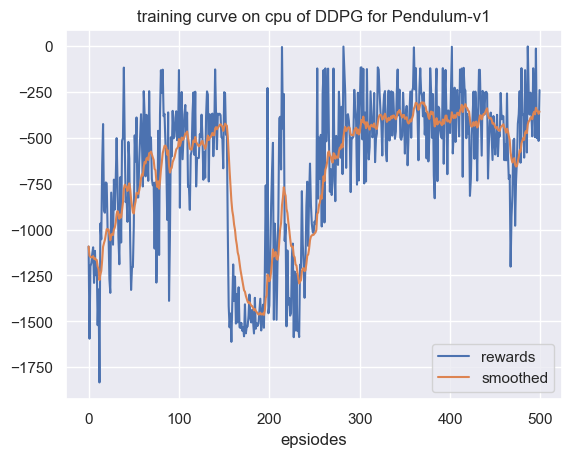

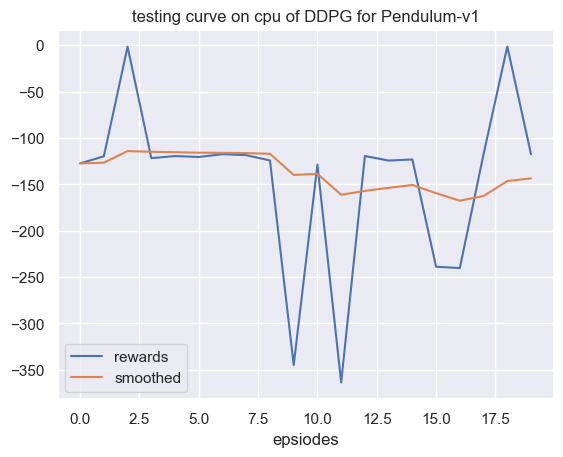

In [7]:
# 获取参数
cfg = get_args() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果

In [ ]:
state = env.reset() 
for i_step in range(500):
    if i_step%10==0:
        print(i_step)
    env.render()
    action = agent.predict_action(state)
    next_state, reward, done, _ = env.step(action)
    state = next_state
env.close()

0


/opt/anaconda3/lib/python3.12/site-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


: 